## Pre-processing

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 100)

In [2]:
# import preprocessing routine
from preprocess_module import fraud_preprocessor

# call preprocessor 
full_df = fraud_preprocessor(i_flag=0)

## Feature Engineering

In [3]:
# create physician count column 
phys_count = full_df.groupby(['AttendingPhysician', 'Provider'])['AttendingPhysician'].count()\
           .reset_index(name='Phys_Count').groupby(['Provider'])['Phys_Count'].count().reset_index()


In [4]:
# create patient count column 
patient_count = full_df.groupby(['Provider', 'BeneID'])['BeneID'].count().reset_index(name='Patient_Count')\
                .groupby('Provider')['Patient_Count'].count().reset_index()

train_features1 = pd.merge(phys_count, patient_count, on='Provider')

In [9]:
patient_count

,Provider,Patient_Count
0,PRV51001,24
1,PRV51003,117
2,PRV51004,138
3,PRV51005,495
4,PRV51007,58
...,...,...
5405,PRV57759,24
5406,PRV57760,9
5407,PRV57761,67
5408,PRV57762,1


In [5]:
# create claim count column 
claim_count = full_df.groupby(['Provider', 'ClaimID'])['ClaimID'].count().reset_index(name='Claim_Count').\
         groupby('Provider')['Claim_Count'].count().reset_index()

train_features2 = pd.merge(train_features1, claim_count, on='Provider')

In [6]:
##create service type column
prov_type = full_df.groupby(['Provider', 'PatientType'])['BeneID'].count().reset_index(name='').drop('', axis=1)
prov_type.head()

# create a dictionary provider by service type
lst_prov_type = list(zip(prov_type['Provider'], prov_type['PatientType']))

# feed in empty dict with values inpatient, outpatient, or both
prov_type_dict = {}

for i in lst_prov_type:
    if i[0] not in prov_type_dict:
        prov_type_dict[i[0]]= i[1]    
    else:
        prov_type_dict[i[0]] = 'Both'
        

# creaete new column type of service by povider
service_type = pd.DataFrame(prov_type_dict.keys(), prov_type_dict.values()).reset_index().\
               rename(columns={'index':'Service_Type', 0:'Provider'})

# add Service column 
train_features3 = pd.merge(train_features2, service_type, on='Provider')

In [7]:
# Duplicate Claims 
full_df2 = full_df.copy()
full_df2['all_duplicates'] = full_df2.duplicated(subset = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'ClmAdmitDiagnosisCode', 'BeneID', 'Provider'], keep=False)

In [12]:
Duplicates = full_df2[full_df2.all_duplicates == True].groupby('Provider')['BeneID'].count().reset_index(name='DuplicateClaims')
train_features4 = pd.merge(train_features3, Duplicates, on = 'Provider')
train_features4

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,DuplicateClaims
0,PRV51001,14,24,25,Both,22
1,PRV51003,44,117,132,Both,160
2,PRV51004,38,138,149,Outpatient,158
3,PRV51005,7,495,1165,Outpatient,764
4,PRV51007,10,58,72,Both,70
...,...,...,...,...,...,...
5095,PRV57757,1,11,11,Inpatient,20
5096,PRV57759,1,24,28,Outpatient,54
5097,PRV57760,3,9,22,Outpatient,8
5098,PRV57761,2,67,82,Outpatient,70


In [21]:
# Claim Duration 
Claim_dur = full_df2.groupby('Provider')['ClaimDuration'].agg('mean').reset_index(name='AvgClaimDuration')
train_features5 = pd.merge(train_features4, Claim_dur, on = 'Provider')
train_features5

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,DuplicateClaims,AvgClaimDuration
0,PRV51001,14,24,25,Both,22,1.194444
1,PRV51003,44,117,132,Both,160,3.816038
2,PRV51004,38,138,149,Outpatient,158,1.197368
3,PRV51005,7,495,1165,Outpatient,764,1.071197
4,PRV51007,10,58,72,Both,70,1.289720
...,...,...,...,...,...,...,...
5095,PRV57757,1,11,11,Inpatient,20,6.523810
5096,PRV57759,1,24,28,Outpatient,54,2.181818
5097,PRV57760,3,9,22,Outpatient,8,0.269231
5098,PRV57761,2,67,82,Outpatient,70,1.683761


In [30]:
full_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,ClaimMonth,HospitalDuration,ClaimDuration,PatientType,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,None,None,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,None,None,None,None,None,None,None,4,6.0,6,Inpatient,1943-01-01,0,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000.0,3204.0,60.0,70.0,1
1,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000.0,PHY390922,None,None,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,None,None,None,None,None,None,None,4,6.0,6,Inpatient,1943-01-01,0,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000.0,3204.0,60.0,70.0,1
2,BENE17521,CLM34721,2009-01-20,2009-02-01,PRV55912,19000.0,PHY349293,PHY370861,PHY363291,2009-01-20,45340,1068.0,2009-02-01,987,4240,2639,2948,40390,45821,28489,5854,2753,E9305,None,7769.0,5849.0,None,None,None,None,1,12.0,12,Inpatient,1913-12-01,0,2,1,0,39,230,12,12,1,1,1,2,1,2,2,1,2,2,2,19000.0,1068.0,100.0,20.0,1
3,BENE21718,CLM72336,2009-10-17,2009-11-04,PRV55912,17000.0,PHY334706,PHY334706,None,2009-10-17,V5789,1068.0,2009-11-04,941,V5789,4168,73313,7812,7993,78830,72273,43812,4019,None,9338.0,None,None,None,None,None,10,18.0,18,Inpatient,1922-10-01,0,1,1,0,39,600,12,12,2,2,2,2,2,2,2,1,1,2,2,17000.0,1068.0,1050.0,540.0,1
4,BENE22934,CLM73394,2009-10-25,2009-10-29,PRV55912,13000.0,PHY390614,PHY323689,PHY363291,2009-10-25,71946,1068.0,2009-10-29,506,71535,71960,4019,V1202,4240,2449,2768,None,None,None,8154.0,None,None,None,None,None,10,4.0,4,Inpatient,1930-07-01,0,2,1,0,39,280,12,12,2,1,2,2,1,2,1,1,1,1,2,27000.0,2136.0,450.0,160.0,1


In [43]:
# Average Cost (reimbursed + deductible) across Providers
full_df2['TotalCharge'] = full_df2['InscClaimAmtReimbursed'] + full_df2['DeductibleAmtPaid']
print('Average Charges of Fraudulent and Non-Fraudulent Providers: \n', full_df2.groupby('PotentialFraud')['TotalCharge'].agg('mean'))
AvgCharge = full_df2.groupby('Provider')['TotalCharge'].agg('mean').reset_index(name='Avg_Cost')
train_features6 = pd.merge(train_features5, AvgCharge, on = 'Provider')
train_features6.head()

Average Charges of Fraudulent and Non-Fraudulent Providers: 
 PotentialFraud
0     813.991093
1    1545.522275
Name: TotalCharge, dtype: float64


,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,DuplicateClaims,AvgClaimDuration,Avg_Cost
0,PRV51001,14,24,25,Both,22,1.194444,4684.833333
1,PRV51003,44,117,132,Both,160,3.816038,5040.405660
2,PRV51004,38,138,149,Outpatient,158,1.197368,356.140351
3,PRV51005,7,495,1165,Outpatient,764,1.071197,247.708738
4,PRV51007,10,58,72,Both,70,1.289720,652.037383


In [44]:
#import train label df
label_train_df = pd.read_csv('Train-1542865627584.csv')

#add label column
features = pd.merge(train_features6, label_train_df, on='Provider')
features.head()

,Provider,Phys_Count,Patient_Count,Claim_Count,Service_Type,DuplicateClaims,AvgClaimDuration,Avg_Cost,PotentialFraud
0,PRV51001,14,24,25,Both,22,1.194444,4684.833333,No
1,PRV51003,44,117,132,Both,160,3.816038,5040.405660,Yes
2,PRV51004,38,138,149,Outpatient,158,1.197368,356.140351,No
3,PRV51005,7,495,1165,Outpatient,764,1.071197,247.708738,Yes
4,PRV51007,10,58,72,Both,70,1.289720,652.037383,No


### Exploratory Data Analysis

Text(0, 0.5, 'Average Cost')

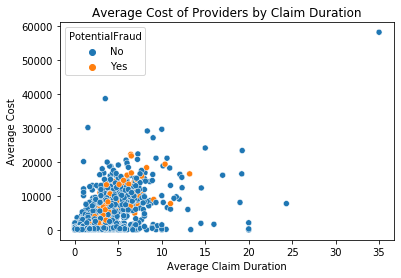

In [48]:
import matplotlib.pyplot as plt
sns.scatterplot(x='AvgClaimDuration', y='Avg_Cost', data=features, hue='PotentialFraud')
plt.title('Average Cost of Providers by Claim Duration')
plt.xlabel('Average Claim Duration')
plt.ylabel('Average Cost')

Text(0, 0.5, 'Duplications')

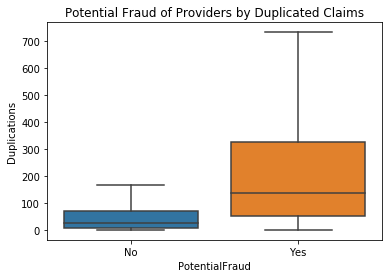

In [49]:
sns.boxplot(x='PotentialFraud', y='DuplicateClaims', data=features, showfliers=False)
plt.title('Potential Fraud of Providers by Duplicated Claims')
plt.ylabel('Duplications')

Text(0.5, 1.0, 'Fraudulent Providers Service Type')

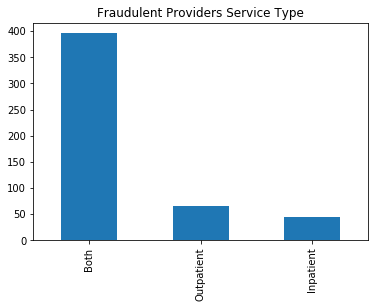

In [56]:
#dataset['frag_family'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%', colors = colors)
features[features.PotentialFraud == 'Yes']['Service_Type'].value_counts().plot(kind = 'bar')
plt.title('Fraudulent Providers Service Type')

Text(0.5, 1.0, 'Non-Fraudulent Providers Service Type')

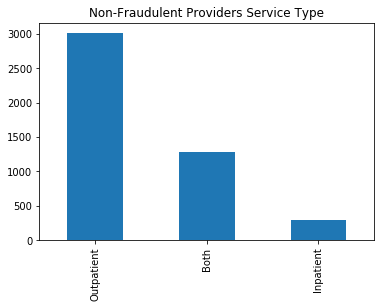

In [57]:
features[features.PotentialFraud == 'No']['Service_Type'].value_counts().plot(kind = 'bar')
plt.title('Non-Fraudulent Providers Service Type')

In [64]:
full_df2.groupby('PotentialFraud')['State'].value_counts()

PotentialFraud  State
0               45       37682
                10       33998
                5        30296
                33       26689
                14       23374
                         ...  
1               43         391
                2          339
                9          304
                41         256
                35         136
Name: State, Length: 104, dtype: int64